In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [0]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [5]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import kaggle

In [7]:
!kaggle competitions list -s tgs-salt

ref                                deadline             category    reward  teamCount  userHasEntered  
---------------------------------  -------------------  --------  --------  ---------  --------------  
tgs-salt-identification-challenge  2018-10-19 23:59:00  Featured  $100,000       3229            True  


In [8]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 48.6MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 67.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.3MB/s]
 98% 160M/163M [00:00<00:00, 154MB/s]
100% 163M/163M [00:01<00:00, 169MB/s]
 66% 25.0M/37.9M [00:00<00:00, 76.1MB/s]
100% 37.9M/37.9M [00:00<00:00, 126MB/s] 


In [9]:
!unzip /content/train.zip

Archive:  /content/train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  inflating: images/d4acb30303.png   
  inflating: images/057eae4f34.png   
  inflating: image

In [10]:
import os
len(os.listdir('/content/masks'))

4000

In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [12]:
import os
os.getcwd()

'/content'

In [0]:
# os.listdir('/kaggle/input/tgs-salt-identification-challenge/train/')

In [0]:
images_path = "/content/images"
masks_path = "/content/masks"

In [15]:
ids = next(os.walk(images_path))[2] # list of names of all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)

In [17]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total = len(ids)):
    # Load images
    img = load_img(images_path + "/" +id_, grayscale = True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(masks_path + "/" + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [18]:
!pip install tensorboardcolab
import tensorflow as tf
%load_ext tensorboard

In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 9)

In [20]:
y_train[0].shape

(128, 128, 1)

(-0.5, 127.5, 127.5, -0.5)

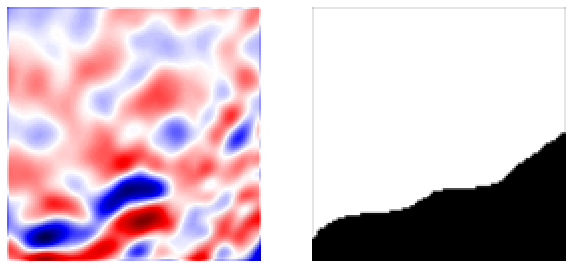

In [21]:
idx = np.random.randint(0, len(X_train))
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx].squeeze(), cmap = "seismic")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(y_train[idx].squeeze(), cmap = "gray")
plt.axis("off")

Text(0.5, 1.0, 'Salt')

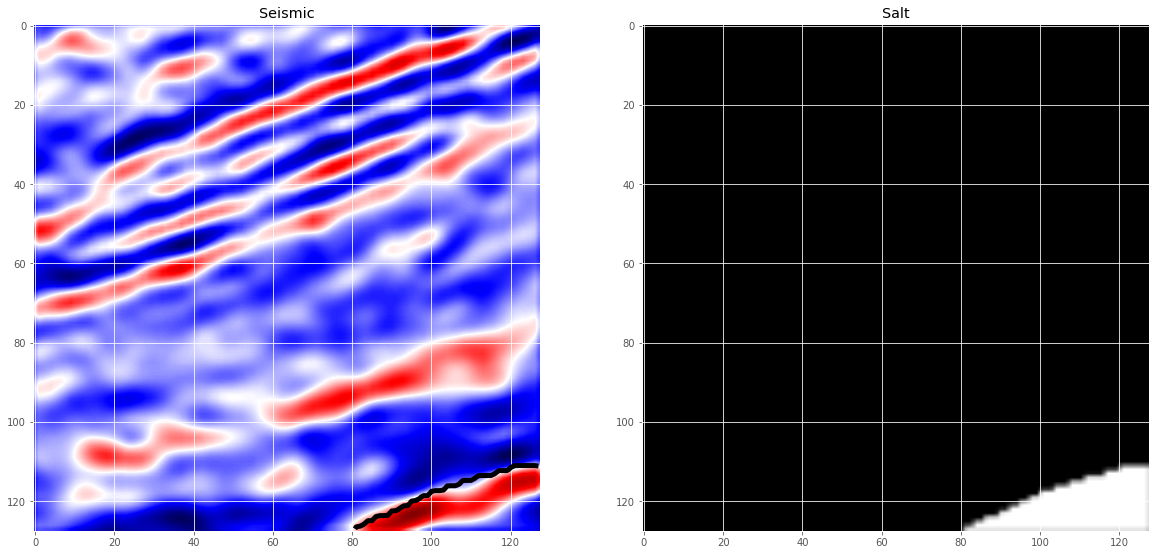

In [22]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [25]:
from tensorboardcolab import *
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://4c829157.ngrok.io


In [26]:
input_img = Input((im_height, im_width, 1), name = 'img')
model = get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True)
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [
    EarlyStopping(patience = 10, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.00001, verbose = 1),
    ModelCheckpoint('model-tgs-salt.h5', verbose = 1, save_best_only = True, save_weights_only = True),
    TensorBoardColabCallback(tbc)
]

In [28]:
results = model.fit(X_train, y_train, batch_size = 32, epochs = 50, callbacks = callbacks,\
                    validation_data = (X_valid, y_valid), verbose = 2)



Train on 3600 samples, validate on 400 samples


Epoch 1/50
 - 25s - loss: 0.4280 - acc: 0.8133 - val_loss: 1.0558 - val_acc: 0.7323

Epoch 00001: val_loss improved from inf to 1.05583, saving model to model-tgs-salt.h5

Epoch 2/50
 - 18s - loss: 0.3056 - acc: 0.8738 - val_loss: 0.9400 - val_acc: 0.7456

Epoch 00002: val_loss improved from 1.05583 to 0.93999, saving model to model-tgs-salt.h5
Epoch 3/50
 - 19s - loss: 0.2814 - acc: 0.8806 - val_loss: 0.4859 - val_acc: 0.8047

Epoch 00003: val_loss improved from 0.93999 to 0.48594, saving model to model-tgs-salt.h5
Epoch 4/50
 - 19s - loss: 0.2517 - acc: 0.8939 - val_loss: 0.4266 - val_acc: 0.8454

Epoch 00004: val_loss improved from 0.48594 to 0.42663, saving model to model-tgs-salt.h5
Epoch 5/50
 - 19s - loss: 0.2490 - acc: 0.8944 - val_loss: 0.3599 - val_acc: 0.8299

Epoch 00005: val_loss improved from 0.42663 to 0.35993, saving model to model-tgs-salt.h5
Epoch 6/50
 - 19s - loss: 0.2274 - acc: 0.9033 - val_loss: 0.2630 - val_acc: 

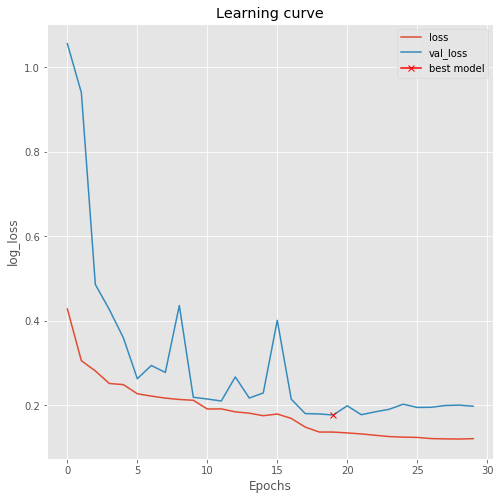

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [31]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose = 1)

400/400 [==============================] - 1s 2ms/step


[0.17709368824958802, 0.9166741943359376]

In [0]:
# os.listdir('/kaggle/input/tgs-salt-identification-challenge/test')

In [35]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose = 1)
preds_val = model.predict(X_valid, verbose = 1)

400/400 [==============================] - 1s 1ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

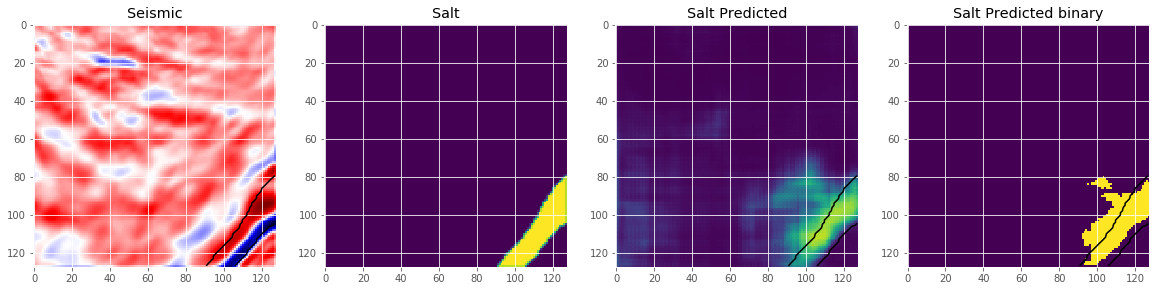

In [38]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

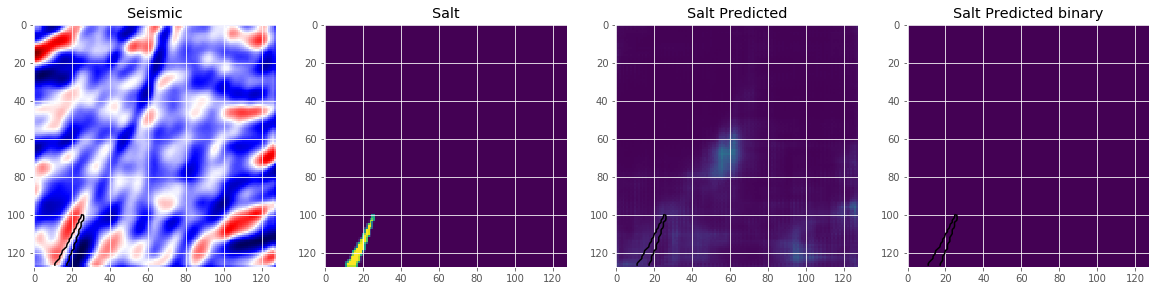

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

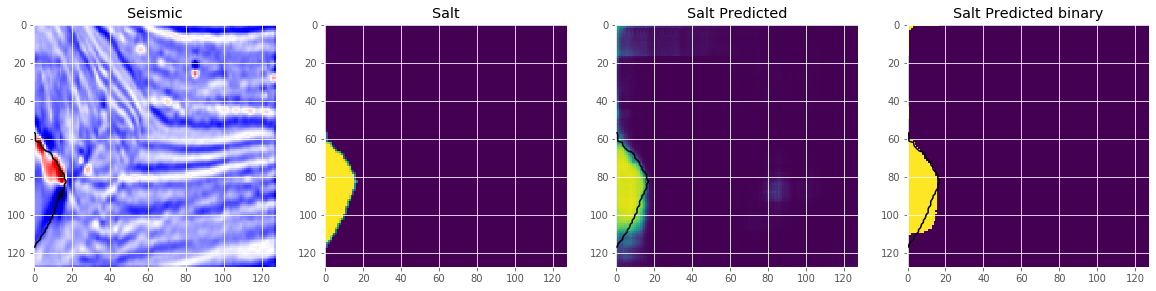

In [40]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

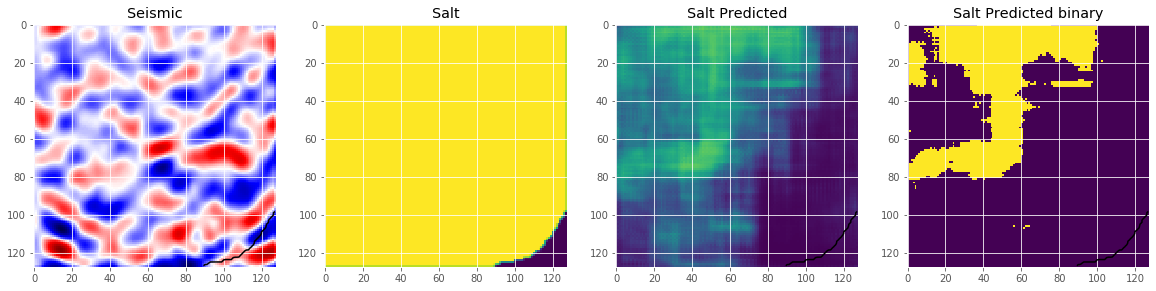

In [41]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix = 19)

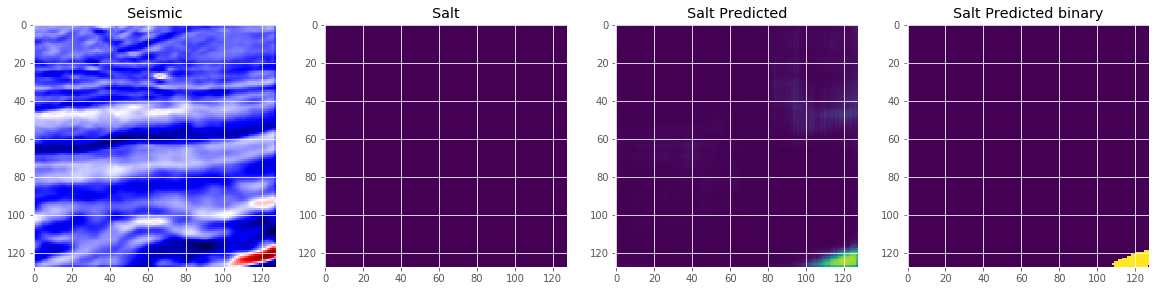

In [42]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

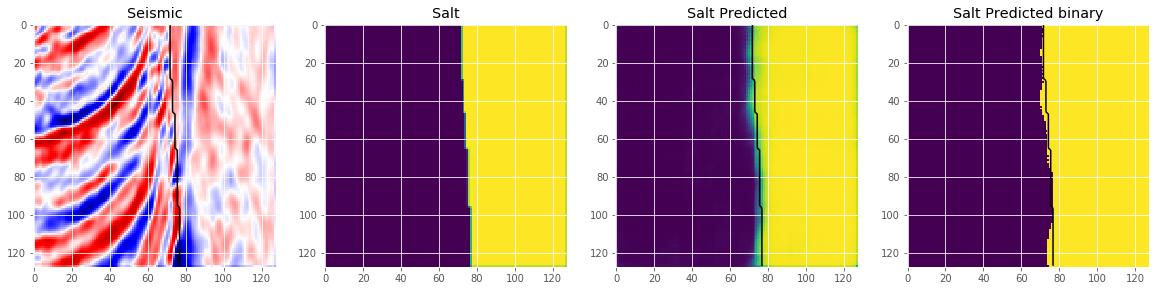

In [43]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)